In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# set random seed reproducibility
torch.manual_seed(42)

In [3]:
# check for GPU availability

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device : {device}")

using device : cuda


In [4]:
df = pd.read_csv("/content/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(60000, 785)

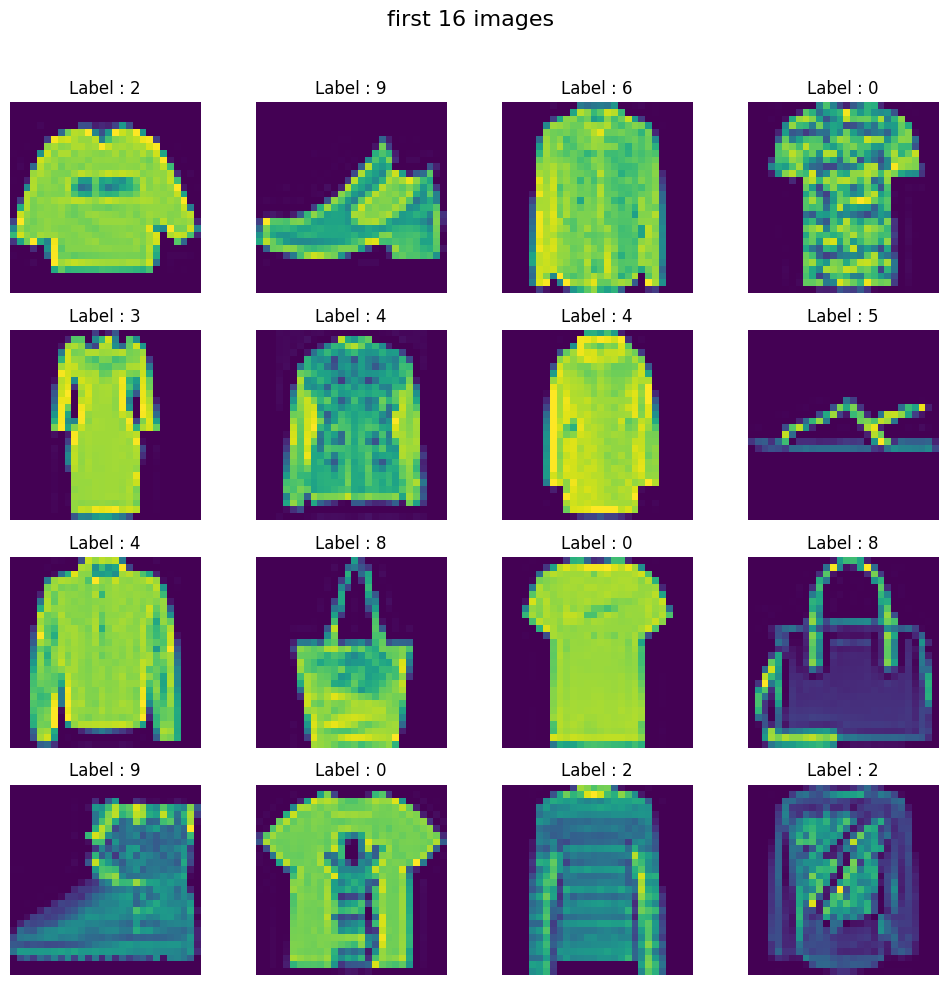

In [6]:
# create 4*4 grid of images

fig,axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("first 16 images ",fontsize=16)

# plot the first 16 images from dataset

for i,ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28) #reshape 28*28
  ax.imshow(img) #display in greyscale
  ax.axis('off') # remove axis for clearner look
  ax.set_title(f"Label : {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96]) #adjust layout to fit the title
plt.show()


In [7]:
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
# scaling the features
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
class CustomDataset(Dataset):

  def __init__(self,features,labels):
    self.features = torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]

In [11]:
train_dataset = CustomDataset(X_train,y_train)

In [12]:
len(train_dataset)

48000

In [13]:
test_dataset = CustomDataset(X_test,y_test)

In [14]:
len(test_dataset)

12000

In [15]:
# create train and test loader

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True,pin_memory=True)

In [21]:
class MyNN(nn.Module):

  def __init__(self,input_features):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(input_features,32,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(32,64,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(64,10)
    )

  def forward(self,x):
    x = self.features(x)
    x = self.classifier(x)

    return x

In [22]:
learning_rate = 0.01
epochs = 100

In [23]:
model = MyNN(1)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [25]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features,batch_labels in train_loader:

    # move data to GPU
    batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs,batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # grad update
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f"Epoch :{epoch + 1}, Loss: {avg_loss}")

Epoch :1, Loss: 0.6555259107748668
Epoch :2, Loss: 0.3873044241890311
Epoch :3, Loss: 0.3279200906852881
Epoch :4, Loss: 0.29005237194523215
Epoch :5, Loss: 0.26536673806483546
Epoch :6, Loss: 0.2475702231588463
Epoch :7, Loss: 0.22967567029843727
Epoch :8, Loss: 0.21423790148148933
Epoch :9, Loss: 0.20271812625726063
Epoch :10, Loss: 0.18961971310464043
Epoch :11, Loss: 0.1787012355091671
Epoch :12, Loss: 0.1693378505675743
Epoch :13, Loss: 0.16049753888168683
Epoch :14, Loss: 0.15198660606145858
Epoch :15, Loss: 0.1446373501950875
Epoch :16, Loss: 0.13869736549351364
Epoch :17, Loss: 0.12882818802880744
Epoch :18, Loss: 0.12294070112487922
Epoch :19, Loss: 0.11800210902451848
Epoch :20, Loss: 0.11187469293596224
Epoch :21, Loss: 0.10486771656634906
Epoch :22, Loss: 0.10134790684313824
Epoch :23, Loss: 0.09390443753187235
Epoch :24, Loss: 0.0908297857530415
Epoch :25, Loss: 0.08675976530377132
Epoch :26, Loss: 0.08219762239224898
Epoch :27, Loss: 0.08024723895724552
Epoch :28, Loss: 0

In [26]:
# set model to evaluate mode
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [27]:
# evaluation code

total = 0
correct = 0

with torch.no_grad():

  for batch_features,batch_labels in test_loader:

    # move data to GPU
    batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)

    outputs = model(batch_features)

    _,predicted = torch.max(outputs,1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted ==batch_labels).sum().item()

print(f'accuracy:{correct/total}')

accuracy:0.9225


In [29]:

# evaluation code on training data

total = 0
correct = 0

with torch.no_grad():

  for batch_features,batch_labels in train_loader:

    # move data to GPU
    batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)

    outputs = model(batch_features)

    _,predicted = torch.max(outputs,1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted ==batch_labels).sum().item()

print(f'accuracy:{correct/total}')


accuracy:0.9998333333333334
